### Instructor Demo: Stock Portfolio Forecasting

This program executes `1000` simulations of stock price trajectory for Johnson & Johnson (`JNJ`) and Micron Technology, Inc. (`MU`) over the next `252` trading days (or year of trading), based on a normal probability distribution of potential daily returns derived from the corresponding sample means and standard deviations. Daily and cumulative portfolio returns are then calculated, using `60%` of capital allocated to `JNJ` and `40%` of capital allocated to `MU`, to analyze the probability distribution and confidence interval of potential ending cumulative portfolio returns.

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi

%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

symbol
0          WRLSR
1            FUV
2  SODA_DELISTED
3           AAME
4           ACIU
5            EGC
6           ACSG
7            ACV
8           ADTX
9           ADXN

### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the list of tickers
tickers = ["JNJ", "MU"]

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-05-04", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-05-04", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for JNJ and MU
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

JNJ                                      MU  \
                             open    high     low   close   volume   open   
2019-05-06 00:00:00-04:00  140.25  142.24  139.93  142.07  3445868  41.40   
2019-05-07 00:00:00-04:00  140.82  141.38  139.06  139.98  5269848  41.68   
2019-05-08 00:00:00-04:00  140.20  140.92  139.70  139.84  3226434  39.86   
2019-05-09 00:00:00-04:00  138.95  139.32  137.64  138.72  4525847  39.10   
2019-05-10 00:00:00-04:00  138.43  139.25  136.41  139.08  3546854  39.01   

                                                               
                              high      low   close    volume  
2019-05-06 00:00:00-04:00  42.2901  41.0000  42.140  23508497  
2019-05-07 00:00:00-04:00  41.9300  39.7300  40.250  28909657  
2019-05-08 00:00:00-04:00  40.4950  39.5800  39.755  24309501  
2019-05-09 00:00:00-04:00  39.6300  38.2000  39.260  26124978  
2019-05-10 00:00:00-04:00  39.2900  37.6452  38.930  28309668

### Drop Extraneous Columns

In [6]:
# Use the `drop` function with the `level` parameter to drop extra columns in the multi-index DataFrame
df.drop(columns=["open", "high", "low", "volume"], level=1, inplace=True)
df.head()

JNJ      MU
                            close   close
2019-05-06 00:00:00-04:00  142.07  42.140
2019-05-07 00:00:00-04:00  139.98  40.250
2019-05-08 00:00:00-04:00  139.84  39.755
2019-05-09 00:00:00-04:00  138.72  39.260
2019-05-10 00:00:00-04:00  139.08  38.930

### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of `JNJ` and `MU`.
daily_returns = df.pct_change()
daily_returns.head()

JNJ        MU
                              close     close
2019-05-06 00:00:00-04:00       NaN       NaN
2019-05-07 00:00:00-04:00 -0.014711 -0.044850
2019-05-08 00:00:00-04:00 -0.001000 -0.012298
2019-05-09 00:00:00-04:00 -0.008009 -0.012451
2019-05-10 00:00:00-04:00  0.002595 -0.008406

### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for `JNJ` and `MU`, respectively
avg_daily_return_jnj = daily_returns.mean()["JNJ"]["close"]
avg_daily_return_mu = daily_returns.mean()["MU"]["close"]
avg_daily_return_mu

0.0009126898533966111

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for `JNJ` and `MU`, respectively
std_dev_daily_return_jnj = daily_returns.std()["JNJ"]["close"]
std_dev_daily_return_mu = daily_returns.std()["MU"]["close"]
std_dev_daily_return_mu

0.03722239843437665

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations and trading days
num_simulations = 1000
num_trading_days = 252

# Set last closing prices of `JNJ` and `MU`
jnj_last_price = df["JNJ"]["close"][-1]
mu_last_price = df["MU"]["close"][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    simulated_price_df = pd.DataFrame()

    # Initialize the simulated prices list with the last closing price of `JNJ` and `MU`
    simulated_jnj_prices = [jnj_last_price]
    simulated_mu_prices = [mu_last_price]
    
    # Simulate the returns for 252 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_jnj_price = simulated_jnj_prices[-1] * (1 + np.random.normal(avg_daily_return_jnj, std_dev_daily_return_jnj))
        simulated_mu_price = simulated_mu_prices[-1] * (1 + np.random.normal(avg_daily_return_mu, std_dev_daily_return_mu))
        
        # Append the simulated price to the list
        simulated_jnj_prices.append(simulated_jnj_price)
        simulated_mu_prices.append(simulated_mu_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["JNJ prices"] = pd.Series(simulated_jnj_prices)
    simulated_price_df["MU prices"] = pd.Series(simulated_mu_prices)

    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()

    # print(simulated_daily_returns)
    
    # Set the portfolio weights (60% JNJ; 40% MU)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column"s simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[f"Simulation {n+1}"] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

Simulation 1  Simulation 2  Simulation 3  Simulation 4  Simulation 5  \
0      1.000000      1.000000      1.000000      1.000000      1.000000   
1      1.012549      0.991136      1.035930      1.034506      1.018303   
2      1.025524      1.003908      1.060912      1.029801      1.026650   
3      1.037109      1.007325      1.051497      1.044517      1.029989   
4      1.014402      1.008302      1.085738      1.074692      1.034770   

   Simulation 6  Simulation 7  Simulation 8  Simulation 9  Simulation 10  ...  \
0      1.000000      1.000000      1.000000      1.000000       1.000000  ...   
1      0.981436      0.988756      1.003309      0.988085       1.012649  ...   
2      0.976513      0.970537      0.964608      0.967136       1.011986  ...   
3      0.967920      0.938301      0.978498      0.949180       0.971291  ...   
4      0.971425      0.954810      0.990361      0.969813       0.974179  ...   

   Simulation 991  Simulation 992  Simulation 993  Simulation 994  \
0        1.000000        1.000000        1.000000        1.000000   
1        0.965095        0.982484        0.980418        1.000704   
2        0.955312        0.992969        0.984533        1.010247   
3        0.953175        1.000082        0.991257        0.988554   
4        0.935027        1.005370        0.985628        1.001946   

   Simulation 995  Simulation 996  Simulation 997  Simulation 998  \
0        1.000000        1.000000        1.000000        1.000000   
1        1.000444        1.011163        0.981569        0.960959   
2        1.003789        1.035764        0.960734        0.956009   
3        0.991188        1.046158        1.000755        0.950160   
4        1.009529        1.039306        0.984434        0.987276   

   Simulation 999  Simulation 1000  
0        1.000000         1.000000  
1        0.985742         1.007850  
2        0.975174         1.012477  
3        0.971146         0.978889  
4        0.943783         0.998370  

[5 rows x 1000 columns]

### Plot the Multiple Simulations of Potential Cumulative Portfolio Returns over the Next Year (252 Trading Days)

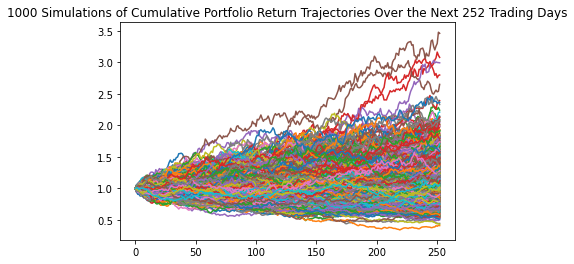

In [11]:
# Use the `plot` function to plot `1000` simulations of the potential trajectories of the portfolio based on 252 trading days
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next 252 Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for project stock prices (prices of each simulation on the 252nd trading day)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

Simulation 1    0.860040
Simulation 2    1.025315
Simulation 3    1.593607
Simulation 4    1.007840
Simulation 5    1.346020
Name: 252, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Portfolio Cumulative Returns on the 252nd Trading Day

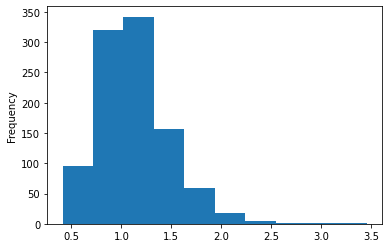

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
ending_cumulative_returns.plot(kind="hist", bins=10)

### Calculate the Probability Distribution of Ending Cumulative Return Ranges

In [14]:
ending_cumulative_returns.value_counts(bins=10) / len(ending_cumulative_returns)

(1.02, 1.325]     0.342
(0.715, 1.02]     0.320
(1.325, 1.63]     0.156
(0.407, 0.715]    0.096
(1.63, 1.935]     0.059
(1.935, 2.24]     0.018
(2.24, 2.544]     0.004
(2.849, 3.154]    0.002
(2.544, 2.849]    0.002
(3.154, 3.459]    0.001
Name: 252, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Cumulative Portfolio Returns

In [15]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.598313
0.975    1.973583
Name: 252, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Cumulative Portfolio Returns 

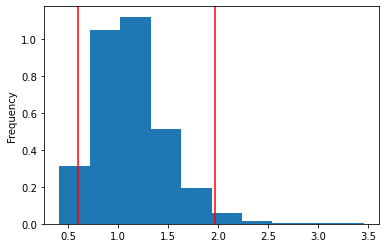

In [16]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
ending_cumulative_returns.plot(kind="hist", density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in the Portfolio over the Next 252 Trading Days

In [17]:
# Set initial investment
initial_investment = 10000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment * confidence_interval.iloc[0]
investment_pnl_upper_bound = initial_investment * confidence_interval.iloc[1]
                                                    
# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 252 trading days will end within in the range of"
      f" ${investment_pnl_lower_bound} and ${investment_pnl_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 252 trading days will end within in the range of $5983.126605923959 and $19735.82793713919
